본 notebook은 필기 한글 데이터를 분석해 맞는 한글 문자를 예측하고자 한다. 

모델은 2개를 이용해 결과는 다음과 같다:

||순실|정확도|검증 순실|검증 정확도|
|---|---|---|---|---|
|기준 CNN 모델|---|---|---|---|
|튜닝 CNN 모델|---|---|---|---|

*본 분석과 예측 왜 중요한가?*
한국어를 도전하는 사람에게 기초지식이며 첫 번째 단계는 바로 한글이다. 물론 이미 비슷한 (정확도가 더 높은) 모델을 사용하는 앱이 있지만 Kaggle에 비슷한 글자씩 글자씩 분석 없으니 제가 한국어를 사랑하는 학생으로서 하고자 했다.

그리고, 직접 한글 글자를 하나씩 만들어 예측은 100% 정확도로 나왔다.

In this notebook, I tried to create a model for prediction Hangul characters based on their images.

Using two different models, the results are the following:

||Loss|Accuracy|Val Loss|Val Accuracy|
|---|---|---|---|---|
|Base CNN Model|---|---|---|---|
|Hyper CNN Model|---|---|---|---|

*Why is this important?*
For Korean learners, Korean is the first stop of their learning journey. There are already applications that use more advanced ML models to help learners learn Hangul, but in Kaggle, I did not find something similar - something that tries to classify Hangul character by character.

Also, I wrote a character for each letter and the accuracy came out as 

# 1. 라이브러리를 불러온다 / Importing libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from sklearn.model_selection import train_test_split

import os
from PIL import Image

# 2. 데이터 로딩 / Data Loading

Thank you, [JAMESCASIA](https://www.kaggle.com/datasets/wayperwayp/hangulkorean-characters/discussion/405491)

In [2]:
main_folder_path = "hangul"

image_data = []
labels = []

def process_images(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            grayscale_img = img.convert('L')  
            resized_img = grayscale_img.resize((64, 64))
            image_data.append(list(resized_img.getdata()))
            labels.append(label)


for letter in ['a', 'ae','b','bb','ch','d','e','eo','eu','g','gg','h','i','j','k','m','n','ng','o','p','r','s','ss','t','u','ya','yae','ye','yo','yu']:
    folder_path = os.path.join(main_folder_path, letter)
    process_images(folder_path, letter)

columns = [f"pixel_{i}" for i in range(len(image_data[0]))] 
df = pd.DataFrame(image_data, columns=columns)
df['label'] = labels

df.to_csv('hangul_dataset.csv', index=False)

print(df.head())

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      255      255      255      255      255      255      255      255   
1      255      255      255      255      255      255      255      255   
2      255      255      255      255      255      255      255      255   
3      255      255      255      255      255      255      255      255   
4      255      255      255      255      255      255      255      255   

   pixel_8  pixel_9  ...  pixel_4087  pixel_4088  pixel_4089  pixel_4090  \
0      255      255  ...         255         255         255         255   
1      255      255  ...         181         178         182         181   
2      255      255  ...         255         255         255         255   
3      255      255  ...         255         255         255         255   
4      255      255  ...         255         255         255         255   

   pixel_4091  pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  
0        

# 3. EDA & Preprocessing

In [3]:
df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded = le.fit_transform(df['label'].values)
decoded = le.inverse_transform(encoded)
df['label2'] = encoded
print('데이터에 다음과 같은 레이블이 포함되어 있다 / The dataset has the following labels: ', le.classes_)

데이터에 다음과 같은 레이블이 포함되어 있다 / The dataset has the following labels:  ['a' 'ae' 'b' 'bb' 'ch' 'd' 'e' 'eo' 'eu' 'g' 'gg' 'h' 'i' 'j' 'k' 'm' 'n'
 'ng' 'o' 'p' 'r' 's' 'ss' 't' 'u' 'ya' 'yae' 'ye' 'yo' 'yu']


In [5]:
classes = le.classes_

In [6]:
dic={0:'a',1:'ae',2:'b',3:'bb',4:'ch',5:'d',6:'e',7:'eo',8:'eu',9:'g',10:'gg',11:'h',12:'i',13:'j',14:'k', 15:'m',16:'n', 17:'ng', 18:'o', 19: 'p', 20: 'r', 21: 's', 22: 'ss', 23:'t', 24: 'u', 25:'ya', 26:'yae', 27:'ye', 28: 'yo', 29: 'yu'}

In [7]:
df.shape

(2400, 4098)

In [8]:
df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,label2
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,a,0
1,255,255,255,255,255,255,255,255,255,255,...,178,182,181,184,185,163,135,126,a,0
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,a,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,a,0
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,a,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,yu,29
2396,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,yu,29
2397,254,254,254,255,255,255,255,255,254,254,...,252,255,254,255,253,228,196,185,yu,29
2398,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,yu,29


# 4. 학습 데이터와 테스트 데이터를 구분함 / Train-test split

In [9]:
X =df.iloc[:,0:4096]
y =df.iloc[:,[4097]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4)

In [10]:
X_train = X_train.astype('float32')/255
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')/255
y_test = y_test.astype('float32')

In [11]:
X_train= X_train.to_numpy()
y_train= y_train.to_numpy()
X_test= X_test.to_numpy()
y_test= y_test.to_numpy()

# 데이터 형식은 64 * 64 * 1로 리쉐이프 한다
# reshape train data and test data into 64 * 64 * 1
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 64, 64, 1).astype('float32')

In [12]:
y_train = to_categorical(y_train, 30)
y_test = to_categorical(y_test, 30)
num_classes = y_train.shape[1]
num_classes

30

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
#         width_shift_range=0.01,
#         height_shift_range=0.01,
#         shear_range=0.1,
#         zoom_range=0.1,
)

train_generator = datagen.flow(X_train, y_train, batch_size=64)
test_generator = datagen.flow(X_test, y_test, batch_size=64, shuffle=False)

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_lr = 0.001
    decay_factor=0.5
    decay_epochs=5
    return initial_lr * (decay_factor ** np.floor(epoch/decay_epochs))

lr_scheduler = LearningRateScheduler(lr_schedule)


# 5. 모델 구성 및 학습 / Model building

## 5.1 기준 CNN 모델 / Basic CNN model

In [15]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 128)               3686528   
                                                                 
 dense_1 (Dense)             (None, 30)                3870      
                                                                 
Total params: 3691230 (14.08 MB)
Trainable params: 3691230 (14.08 MB)
Non-trainable params: 0 (0.00 Byte)
________________

### 5.1.1 기준 모델 학습 / Base model training

In [16]:
# model1 = model.fit(X_train, y_train,batch_size=128, epochs=20, validation_data=(X_test, y_test))

model1 = model.fit(train_generator, steps_per_epoch=len(X_train) // 64, epochs=20, validation_data=test_generator, validation_steps=len(X_test)//64,callbacks=[lr_scheduler])

Epoch 1/20
22/22 [==============================] - 1s 25ms/step - loss: 3.4116 - accuracy: 0.1061 - val_loss: 2.9770 - val_accuracy: 0.2281 - lr: 0.0010
Epoch 2/20
22/22 [==============================] - 1s 24ms/step - loss: 2.5162 - accuracy: 0.3743 - val_loss: 2.1358 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/20
22/22 [==============================] - 1s 24ms/step - loss: 1.5802 - accuracy: 0.6156 - val_loss: 1.4558 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 4/20
22/22 [==============================] - 1s 24ms/step - loss: 0.9774 - accuracy: 0.7631 - val_loss: 1.1399 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 5/20
22/22 [==============================] - 1s 24ms/step - loss: 0.6897 - accuracy: 0.8147 - val_loss: 0.8886 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 6/20
22/22 [==============================] - 1s 24ms/step - loss: 0.4863 - accuracy: 0.8953 - val_loss: 0.7848 - val_accuracy: 0.7844 - lr: 5.0000e-04
Epoch 7/20
22/22 [==============================] - 1s 25ms/step - loss:

### 5.1.2 기준 모델 손실 및 성능 평가 / Base model loss and accuracy

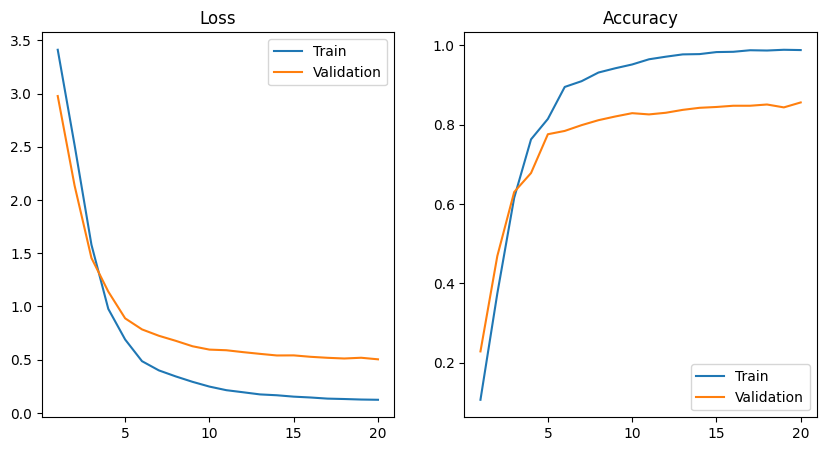

In [17]:
start = 1
end = 20

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(start,end+1), model1.history['loss'][start-1:end], label='Train')
axes[0].plot(range(start,end+1), model1.history['val_loss'][start-1:end], label='Validation')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(range(start,end+1), model1.history['accuracy'][start-1:end], label='Train')
axes[1].plot(range(start,end+1), model1.history['val_accuracy'][start-1:end], label='Validation')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.show()

표본 예측 / Sample prediction

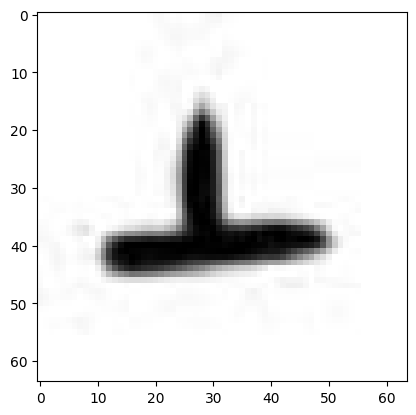

In [18]:
i=100
plt.imshow(X_test[[i]].reshape(64,64),cmap='gray')

In [19]:
prediction=model.predict(X_test[[i]]) 
prediction

1/1 [==============================] - 0s 30ms/step


array([[5.5006833e-05, 4.9896480e-04, 2.1068486e-06, 1.1254924e-05,
        2.7504559e-05, 4.3362577e-04, 6.5004765e-06, 1.3822555e-02,
        9.7939302e-04, 2.4767954e-07, 2.5178381e-06, 4.4988792e-05,
        4.7242460e-03, 5.5094096e-03, 1.9293172e-06, 1.0709474e-07,
        2.2325751e-04, 7.8309040e-07, 8.5210240e-01, 4.3792979e-06,
        7.9849524e-05, 6.7932256e-02, 2.0726871e-05, 2.1472390e-06,
        1.8534664e-04, 9.2166039e-04, 6.6292283e-05, 3.9468241e-06,
        5.2332301e-02, 4.3085711e-06]], dtype=float32)

In [20]:
print("정답은 / The answer is: ",dic[np.argmax(prediction)])

정답은 / The answer is:  o


### 5.1.3 기준 모델의 혼동 행렬 / Base model's confusion matrix 

30/30 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.66      0.78      0.71        32
           1       0.68      0.84      0.75        32
           2       0.86      0.97      0.91        32
           3       1.00      0.91      0.95        32
           4       0.90      0.81      0.85        32
           5       0.85      0.88      0.86        32
           6       0.80      0.88      0.84        32
           7       0.91      0.97      0.94        32
           8       0.88      0.94      0.91        32
           9       0.94      0.97      0.95        32
          10       0.86      0.97      0.91        32
          11       1.00      0.69      0.81        32
          12       0.92      0.75      0.83        32
          13       0.84      0.81      0.83        32
          14       0.88      0.91      0.89        32
          15       0.89      0.78      0.83        32
          16       0.79     

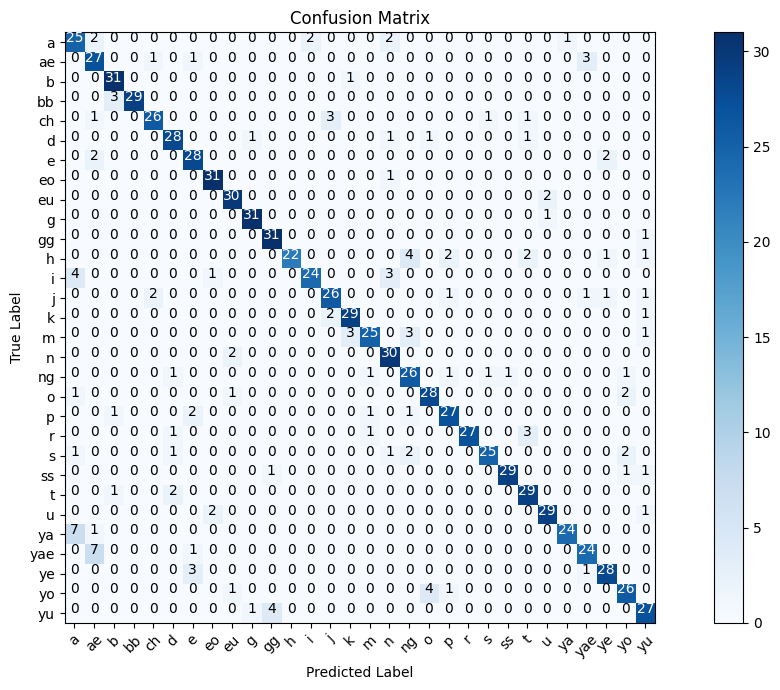

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_true = y_test 

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(classification_report(y_true_labels, y_pred_labels))

plt.figure(figsize=(12, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [22]:
incorrect_predictions = {}
for true_class in range(len(classes)):
    if conf_matrix[true_class, true_class] != np.sum(conf_matrix[true_class]) - conf_matrix[true_class, true_class]:
        predicted_classes = np.where(conf_matrix[true_class] > 0)[0]
        predicted_with_count = {classes[pred_class]: conf_matrix[true_class, pred_class]
                                for pred_class in predicted_classes if pred_class != true_class}
        incorrect_predictions[classes[true_class]] = {
            'count': np.sum(conf_matrix[true_class]) - conf_matrix[true_class, true_class],
            'predicted_with': predicted_with_count
        }

print("True Label\tPredicted Wrong\tPredicted Label (Count)")
print("=====================================================")
for true_label, info in incorrect_predictions.items():
    predicted_with = ', '.join([f"{pred_label} ({count})" for pred_label, count in info['predicted_with'].items()])
    print(f"{true_label}\t\t{info['count']}\t\t{predicted_with}")

True Label	Predicted Wrong	Predicted Label (Count)
a		7		ae (2), i (2), n (2), ya (1)
ae		5		ch (1), e (1), yae (3)
b		1		k (1)
bb		3		b (3)
ch		6		ae (1), j (3), s (1), t (1)
d		4		g (1), n (1), o (1), t (1)
e		4		ae (2), ye (2)
eo		1		n (1)
eu		2		u (2)
g		1		u (1)
gg		1		yu (1)
h		10		ng (4), p (2), t (2), ye (1), yu (1)
i		8		a (4), eo (1), n (3)
j		6		ch (2), p (1), yae (1), ye (1), yu (1)
k		3		j (2), yu (1)
m		7		k (3), ng (3), yu (1)
n		2		eu (2)
ng		6		d (1), m (1), p (1), s (1), ss (1), yo (1)
o		4		a (1), eu (1), yo (2)
p		5		b (1), e (2), m (1), ng (1)
r		5		d (1), m (1), t (3)
s		7		a (1), d (1), n (1), ng (2), yo (2)
ss		3		gg (1), yo (1), yu (1)
t		3		b (1), d (2)
u		3		eo (2), yu (1)
ya		8		a (7), ae (1)
yae		8		ae (7), e (1)
ye		4		e (3), yae (1)
yo		6		eu (1), o (4), p (1)
yu		5		g (1), gg (4)


## 5.2 CNN 모델 - 하이퍼파라미터 튜닝  / Hyperparam tuning

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(64, 64, 1))) 
    
    
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=5)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Int(f'conv_{i}_kernel', min_value=3, max_value=7),
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=32),
        activation='relu'
    ))
    model.add(layers.Dense(num_classes, activation='softmax'))  
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=10,  
    directory='my_tuning_dir',  
    project_name='my_cnn_tuning' 
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

INFO:tensorflow:Reloading Tuner from my_tuning_dir/my_cnn_tuning/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [24]:
best_model.save('hangul_best_model.keras')

### 5.2.1 최적 모델 학습 / Optimal model training

In [25]:
best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
45/45 [==============================] - 35s 771ms/step - loss: 3.4096 - accuracy: 0.0278 - val_loss: 3.3298 - val_accuracy: 0.0615
Epoch 2/20
45/45 [==============================] - 35s 784ms/step - loss: 1.9218 - accuracy: 0.4354 - val_loss: 0.5772 - val_accuracy: 0.8021
Epoch 3/20
45/45 [==============================] - 37s 828ms/step - loss: 0.3592 - accuracy: 0.8826 - val_loss: 0.3030 - val_accuracy: 0.8938
Epoch 4/20
45/45 [==============================] - 38s 845ms/step - loss: 0.1372 - accuracy: 0.9500 - val_loss: 0.2368 - val_accuracy: 0.9292
Epoch 5/20
45/45 [==============================] - 36s 803ms/step - loss: 0.0806 - accuracy: 0.9722 - val_loss: 0.1288 - val_accuracy: 0.9635
Epoch 6/20
45/45 [==============================] - 36s 809ms/step - loss: 0.0387 - accuracy: 0.9854 - val_loss: 0.1288 - val_accuracy: 0.9667
Epoch 7/20
45/45 [==============================] - 36s 794ms/step - loss: 0.0152 - accuracy: 0.9937 - val_loss: 0.1114 - val_accuracy: 0.9677

### 5.2.2 최적 모델의 혼동 행렬 / Optimal model's confusion matrix

30/30 [==============================] - 6s 202ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      1.00      1.00        32
           2       1.00      1.00      1.00        32
           3       1.00      1.00      1.00        32
           4       1.00      0.97      0.98        32
           5       1.00      0.97      0.98        32
           6       1.00      1.00      1.00        32
           7       0.97      1.00      0.98        32
           8       1.00      1.00      1.00        32
           9       1.00      1.00      1.00        32
          10       1.00      0.97      0.98        32
          11       0.94      0.97      0.95        32
          12       1.00      0.88      0.93        32
          13       0.97      1.00      0.98        32
          14       1.00      1.00      1.00        32
          15       0.94      0.97      0.95        32
          16       0.91   

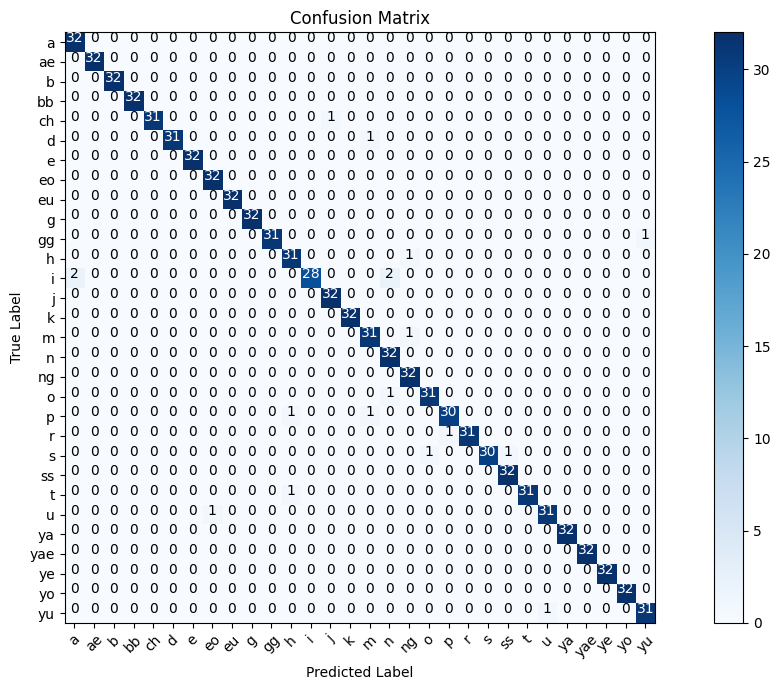

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_model.predict(X_test)
y_true = y_test  

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(classification_report(y_true_labels, y_pred_labels))

plt.figure(figsize=(12, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

In [27]:
incorrect_predictions = {}
for true_class in range(len(classes)):
    if conf_matrix[true_class, true_class] != np.sum(conf_matrix[true_class]) - conf_matrix[true_class, true_class]:
        predicted_classes = np.where(conf_matrix[true_class] > 0)[0]
        predicted_with_count = {classes[pred_class]: conf_matrix[true_class, pred_class]
                                for pred_class in predicted_classes if pred_class != true_class}
        incorrect_predictions[classes[true_class]] = {
            'count': np.sum(conf_matrix[true_class]) - conf_matrix[true_class, true_class],
            'predicted_with': predicted_with_count
        }

print("True Label\tPredicted Wrong\tPredicted Label (Count)")
print("=====================================================")
for true_label, info in incorrect_predictions.items():
    predicted_with = ', '.join([f"{pred_label} ({count})" for pred_label, count in info['predicted_with'].items()])
    print(f"{true_label}\t\t{info['count']}\t\t{predicted_with}")

True Label	Predicted Wrong	Predicted Label (Count)
a		0		
ae		0		
b		0		
bb		0		
ch		1		j (1)
d		1		m (1)
e		0		
eo		0		
eu		0		
g		0		
gg		1		yu (1)
h		1		ng (1)
i		4		a (2), n (2)
j		0		
k		0		
m		1		ng (1)
n		0		
ng		0		
o		1		n (1)
p		2		h (1), m (1)
r		1		p (1)
s		2		o (1), ss (1)
ss		0		
t		1		h (1)
u		1		eo (1)
ya		0		
yae		0		
ye		0		
yo		0		
yu		1		u (1)


# 6. 새로운 데이터 예측 / Prediction of unseen data

## 6.1 기준 모델 / Base model

1/1 [==============================] - 0s 7ms/step


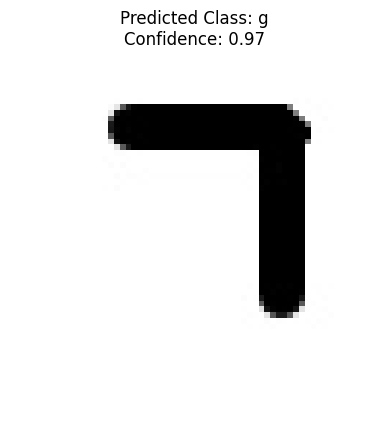

1/1 [==============================] - 0s 6ms/step


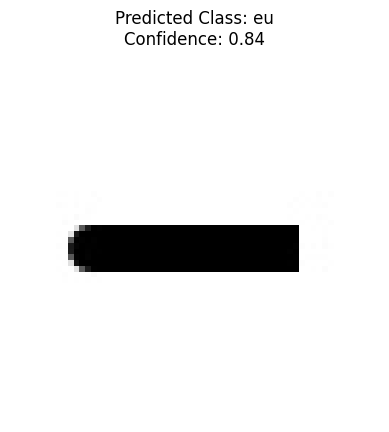

1/1 [==============================] - 0s 7ms/step


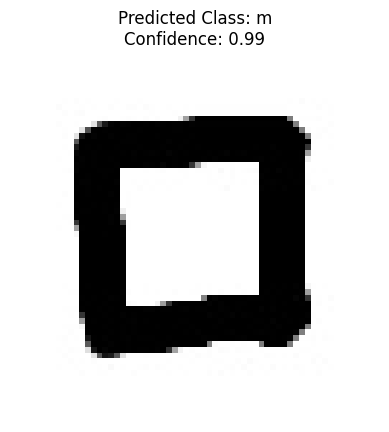

1/1 [==============================] - 0s 8ms/step


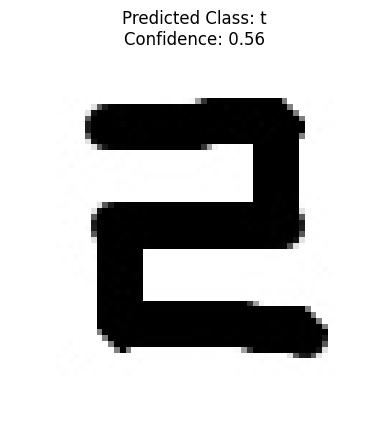

1/1 [==============================] - 0s 6ms/step


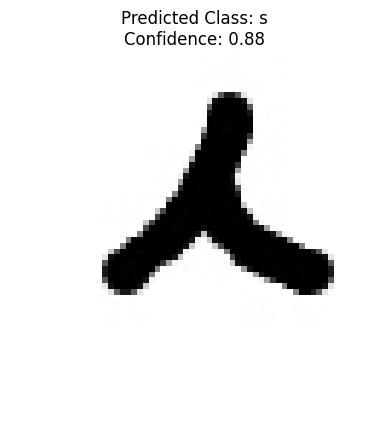

1/1 [==============================] - 0s 7ms/step


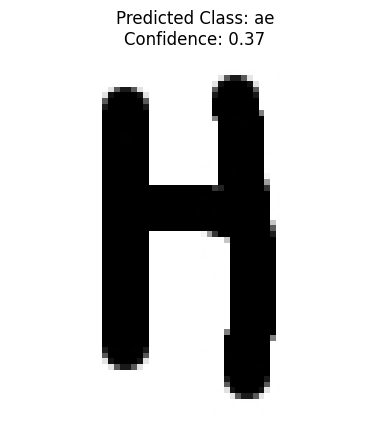

1/1 [==============================] - 0s 7ms/step


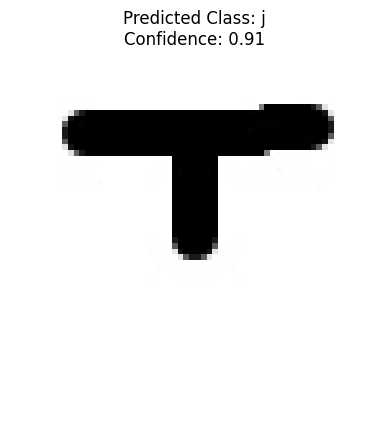

1/1 [==============================] - 0s 6ms/step


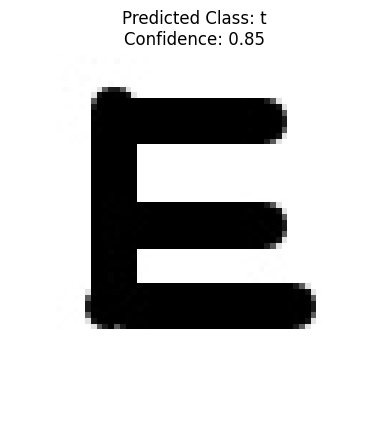

1/1 [==============================] - 0s 7ms/step


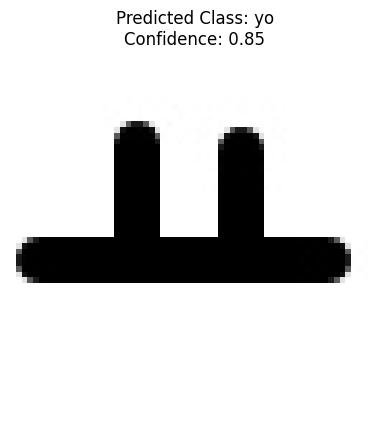

1/1 [==============================] - 0s 6ms/step


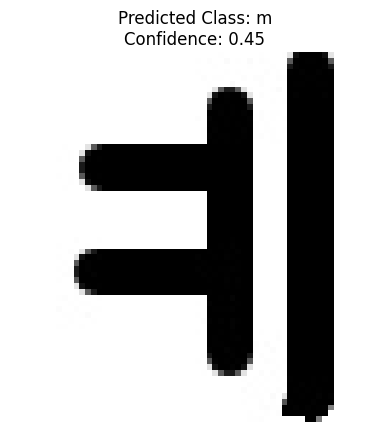

1/1 [==============================] - 0s 7ms/step


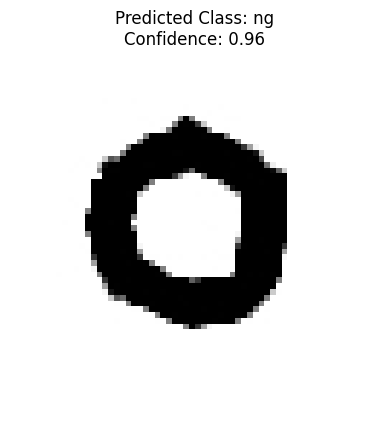

1/1 [==============================] - 0s 6ms/step


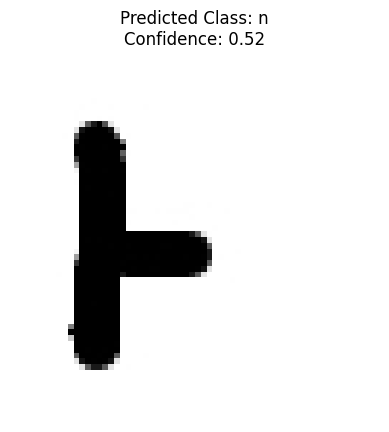

1/1 [==============================] - 0s 6ms/step


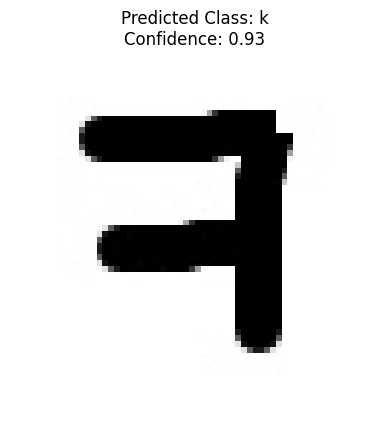

1/1 [==============================] - 0s 6ms/step


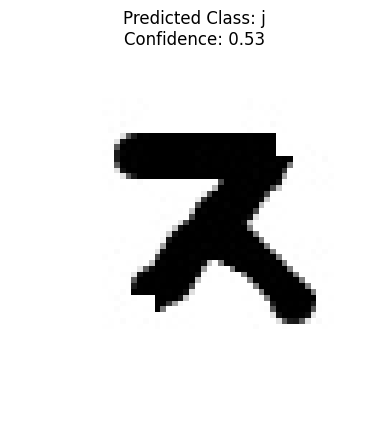

1/1 [==============================] - 0s 7ms/step


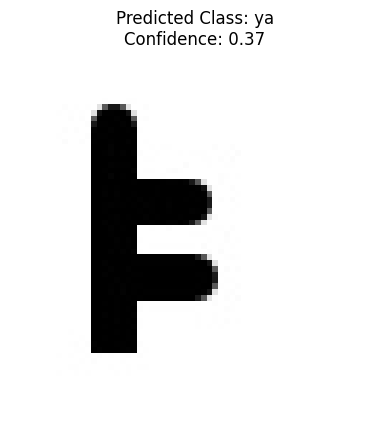

1/1 [==============================] - 0s 6ms/step


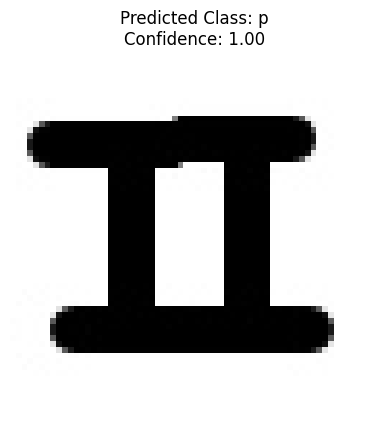

1/1 [==============================] - 0s 7ms/step


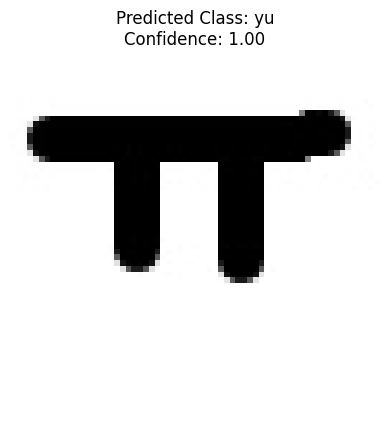

1/1 [==============================] - 0s 6ms/step


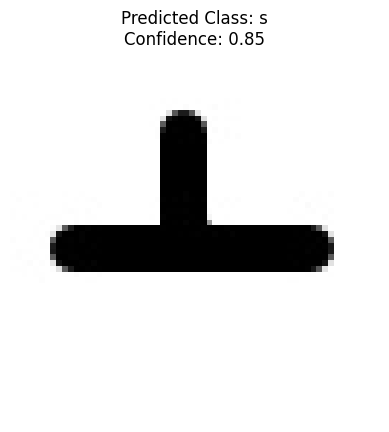

1/1 [==============================] - 0s 7ms/step


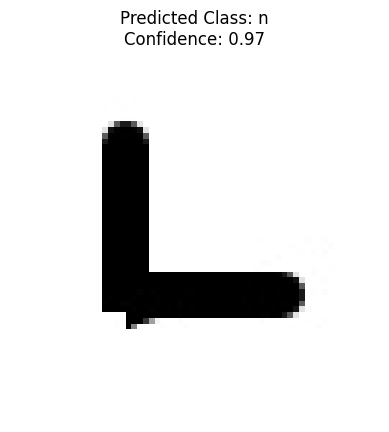

1/1 [==============================] - 0s 7ms/step


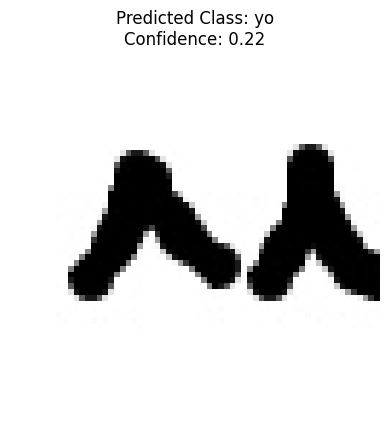

1/1 [==============================] - 0s 7ms/step


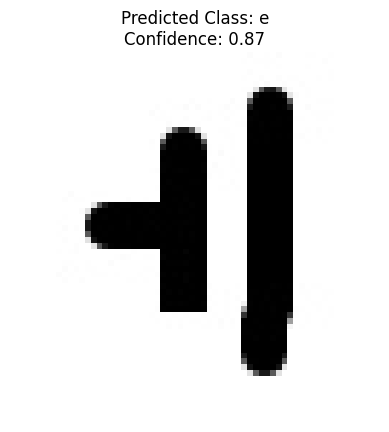

1/1 [==============================] - 0s 6ms/step


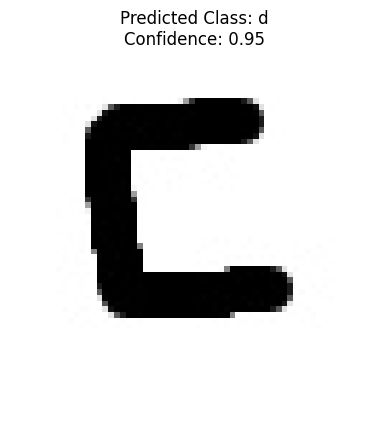

1/1 [==============================] - 0s 6ms/step


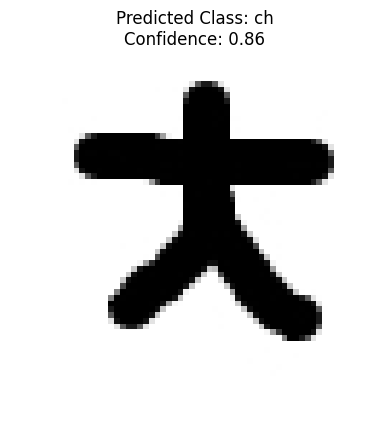

1/1 [==============================] - 0s 7ms/step


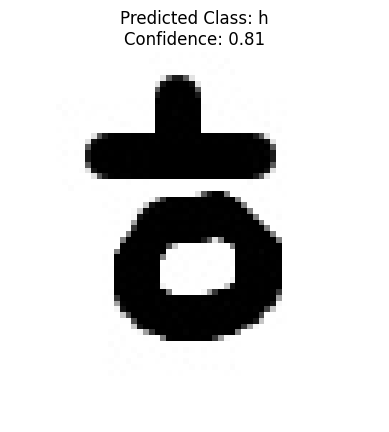

1/1 [==============================] - 0s 6ms/step


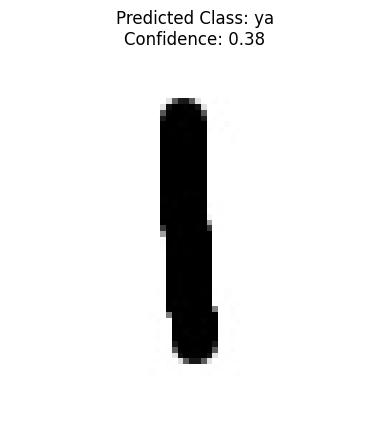

1/1 [==============================] - 0s 7ms/step


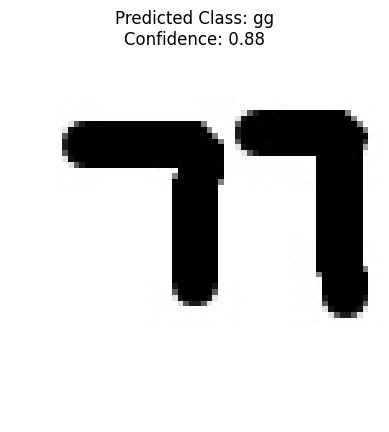

1/1 [==============================] - 0s 7ms/step


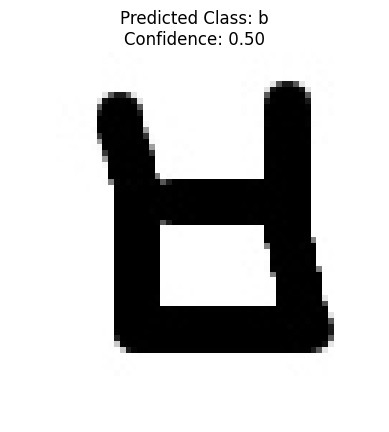

1/1 [==============================] - 0s 7ms/step


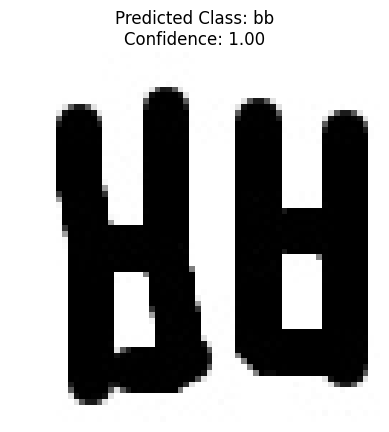

1/1 [==============================] - 0s 8ms/step


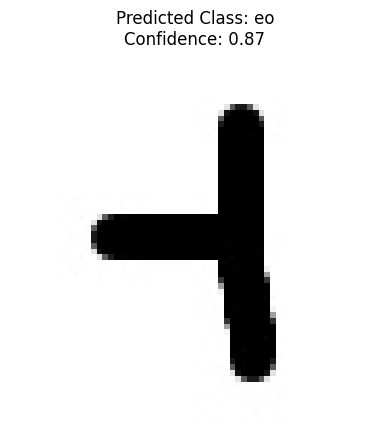

1/1 [==============================] - 0s 7ms/step


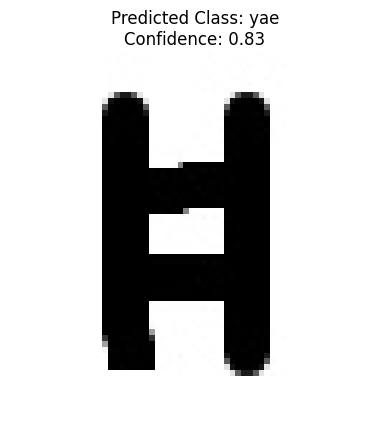

In [28]:
image_directory = 'hangul_written_test'

for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(image_directory, filename)
        
        img = Image.open(image_path)
        input_width, input_height = 64, 64
        inverted_img = img.resize((input_width, input_height))
        img_gray = inverted_img.convert('L')
        img_array = np.array(img_gray)
        img_array = img_array.astype('float32')
        img_array /= 255.0
        img_array = np.expand_dims(img_array, axis=0)
        img_array = np.expand_dims(img_array, axis=-1)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = dic[predicted_class_index]
        confidence_score = predictions[0, predicted_class_index]

        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted Class: {predicted_class_label}\nConfidence: {confidence_score:.2f}")
        plt.axis('off')
        plt.show()

## 6.2 최적 모델 / Hyper model

1/1 [==============================] - 0s 40ms/step


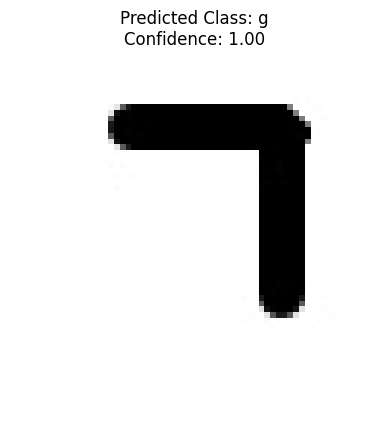

1/1 [==============================] - 0s 20ms/step


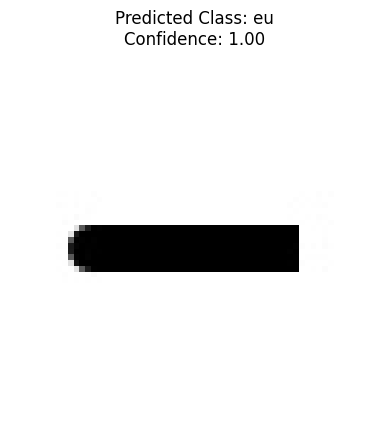

1/1 [==============================] - 0s 19ms/step


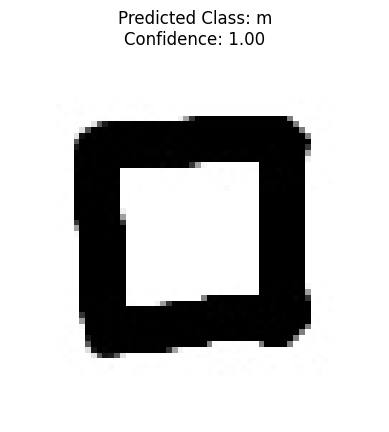

1/1 [==============================] - 0s 19ms/step


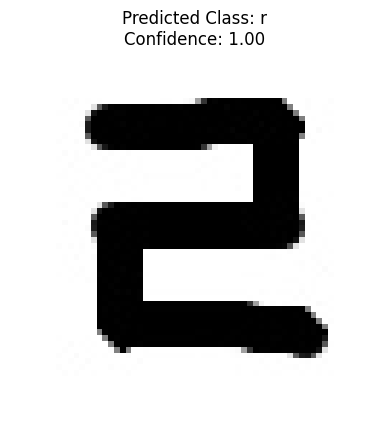

1/1 [==============================] - 0s 19ms/step


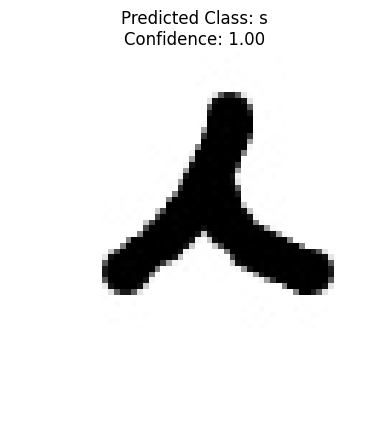

1/1 [==============================] - 0s 20ms/step


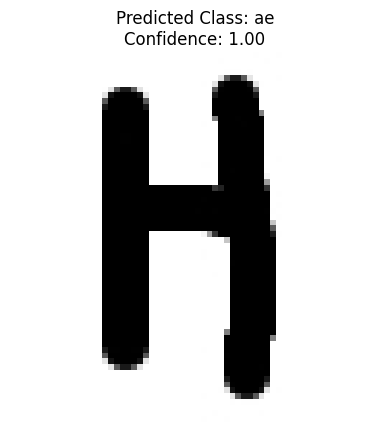

1/1 [==============================] - 0s 19ms/step


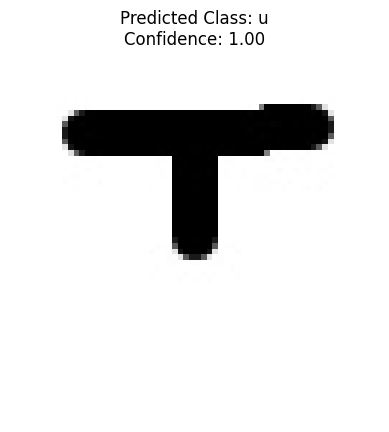

1/1 [==============================] - 0s 19ms/step


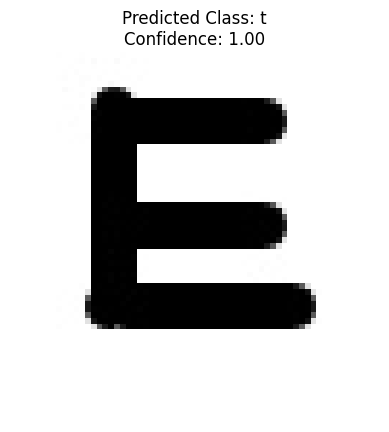

1/1 [==============================] - 0s 19ms/step


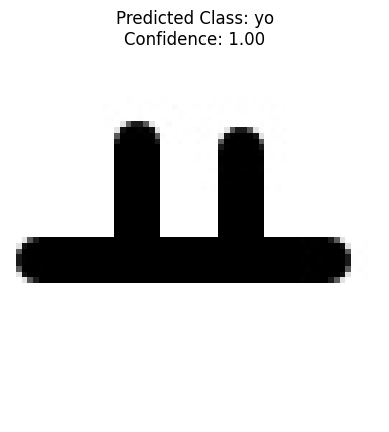

1/1 [==============================] - 0s 17ms/step


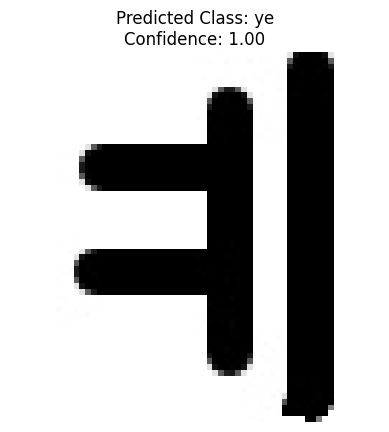

1/1 [==============================] - 0s 18ms/step


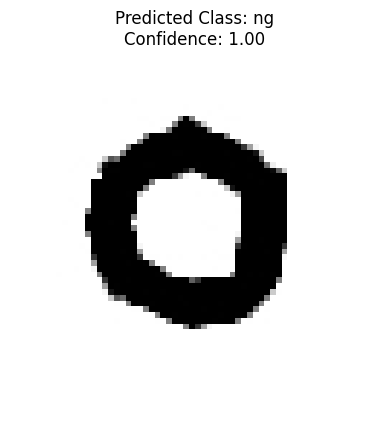

1/1 [==============================] - 0s 18ms/step


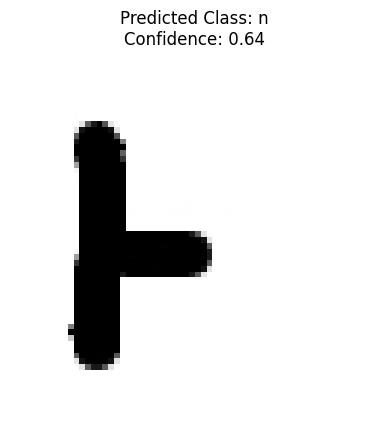

1/1 [==============================] - 0s 18ms/step


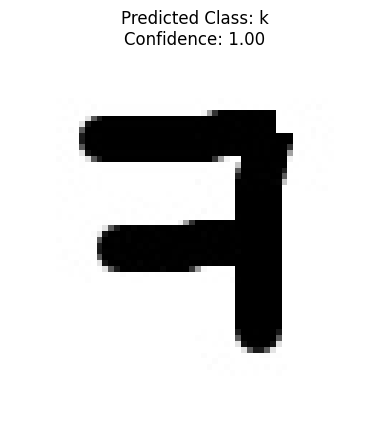

1/1 [==============================] - 0s 18ms/step


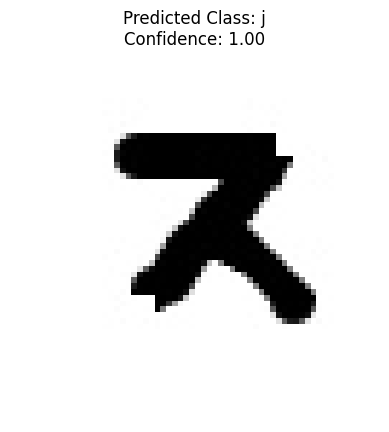

1/1 [==============================] - 0s 19ms/step


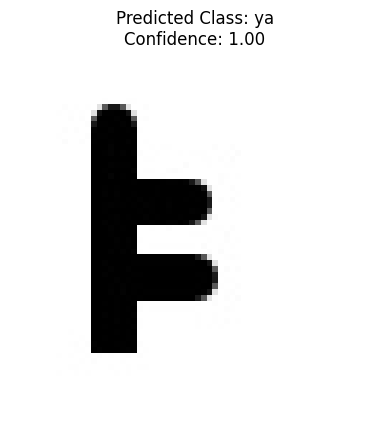

1/1 [==============================] - 0s 17ms/step


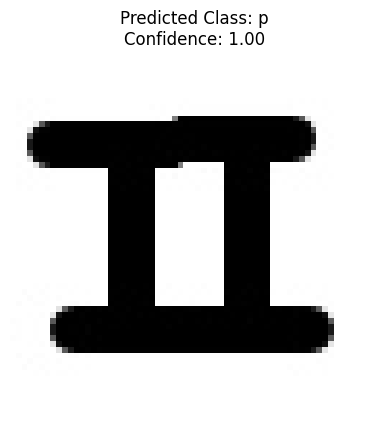

1/1 [==============================] - 0s 18ms/step


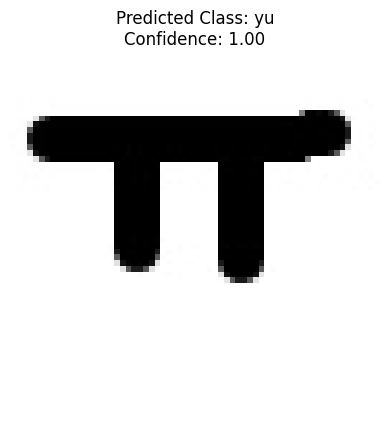

1/1 [==============================] - 0s 18ms/step


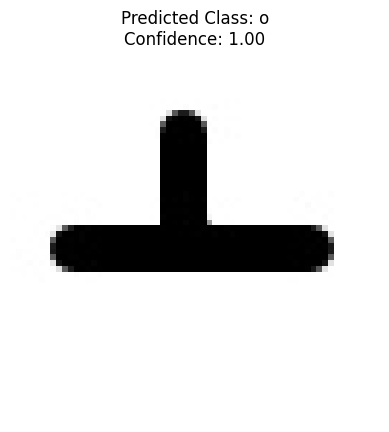

1/1 [==============================] - 0s 19ms/step


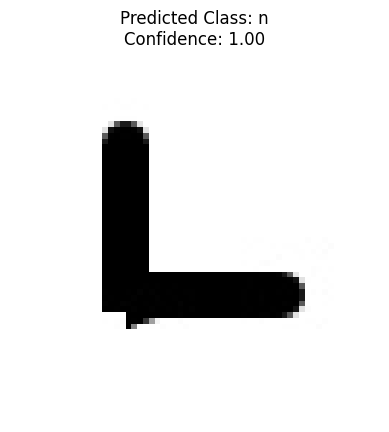

1/1 [==============================] - 0s 18ms/step


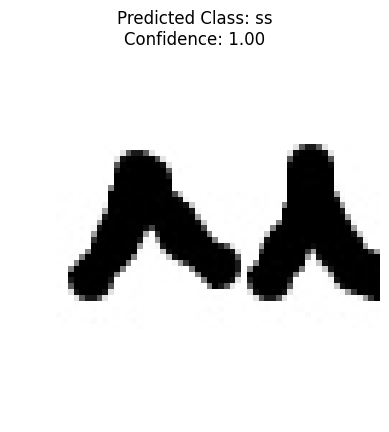

1/1 [==============================] - 0s 17ms/step


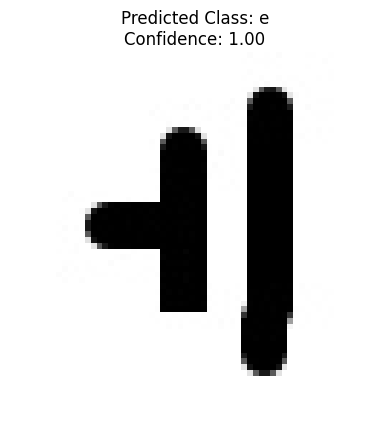

1/1 [==============================] - 0s 19ms/step


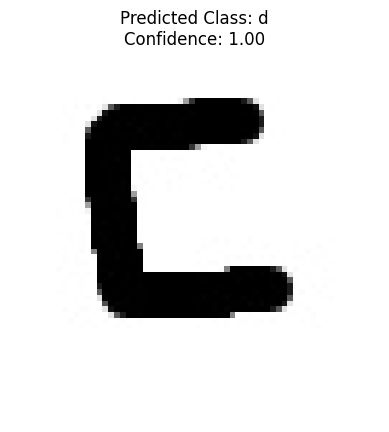

1/1 [==============================] - 0s 18ms/step


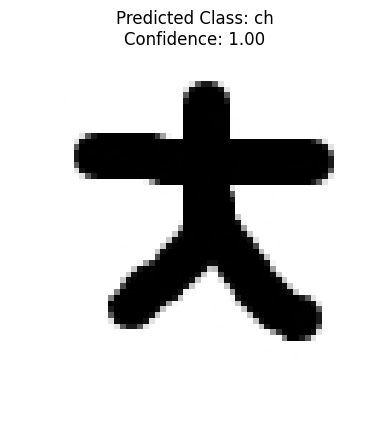

1/1 [==============================] - 0s 18ms/step


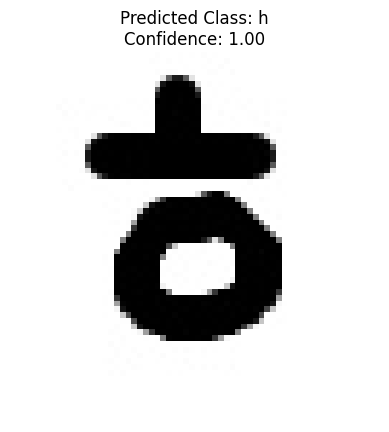

1/1 [==============================] - 0s 17ms/step


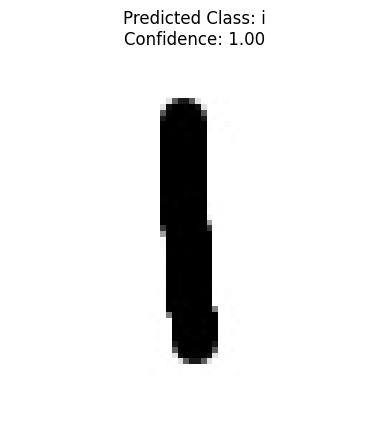

1/1 [==============================] - 0s 17ms/step


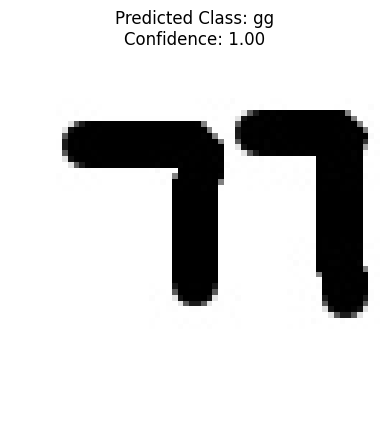

1/1 [==============================] - 0s 18ms/step


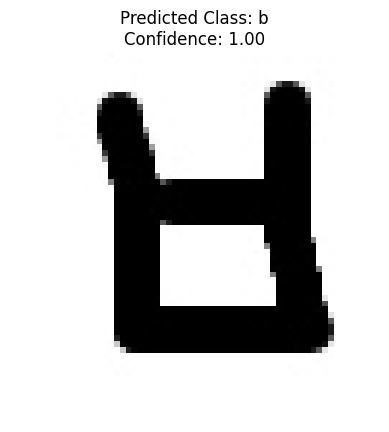

1/1 [==============================] - 0s 19ms/step


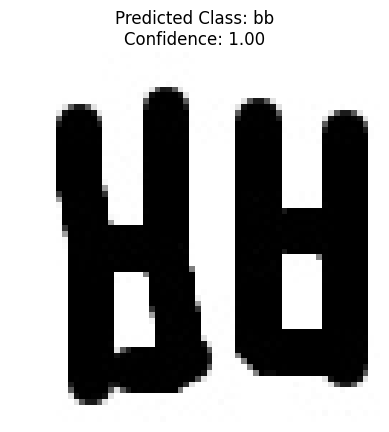

1/1 [==============================] - 0s 25ms/step


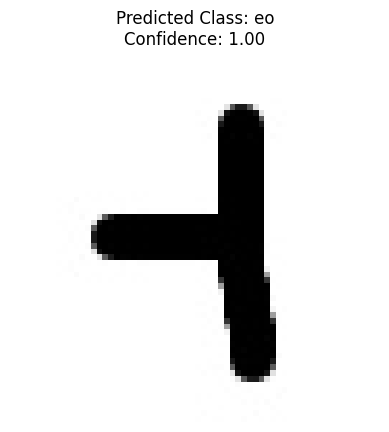

1/1 [==============================] - 0s 17ms/step


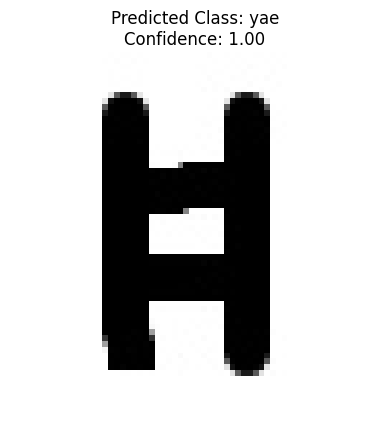

In [29]:
image_directory = 'hangul_written_test'

for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(image_directory, filename)
        
        img = Image.open(image_path)
        input_width, input_height = 64, 64
        inverted_img = img.resize((input_width, input_height))
        img_gray = inverted_img.convert('L')
        img_array = np.array(img_gray)
        img_array = img_array.astype('float32')
        img_array /= 255.0
        img_array = np.expand_dims(img_array, axis=0)
        img_array = np.expand_dims(img_array, axis=-1)

        predictions = best_model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class_label = dic[predicted_class_index]
        confidence_score = predictions[0, predicted_class_index]

        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted Class: {predicted_class_label}\nConfidence: {confidence_score:.2f}")
        plt.axis('off')
        plt.show()

# 7. 결과 분석

하이퍼파라미터 튜닝을 한 모델은 기준 모델보다 역시 더 정확한 결과를 가져왔다. 각 글자 데이터가 (시잔 80잔씩) 작은데도 높고 마음에 드는 예측을 하여 다행이다. 정확한데도 불구하고 데이터가 많이 없기도 하고 어떤 문자의 글씨체 거의 같고 한글 문자 글씨체가 다양해서 다른, 학습을 안 한 스타일로 쓴 문자를 예측하려면 평가가 좋을지도 모른다. 

앞으로 본 모델이 어떻게 향상시킬까? 
 - 데이터 증강 (데이터가 작은데도 이로 정확도를 향상시킬 거 같다)
 - 배치 정규화
 - 하이퍼파라미터 튜닝 (본 notebook에서 Keras Tuning 사용했는데 베이지안 최적화와 그리드 서치, 랜덤 서치 등이 있다)
 - 기타

The model which uses hyperParam tuning is (not surprisingly) more accurate than the baseline model. Nevertheless, the used data is faily limited (80 pictures per character), some of the characters are written in a certain style, and korean people can write characters in multiple ways, so if a new style is used, the model's prediction could be wrong. 

How can the model be improved?
 - Data augmentation (I tried as well, but I did not find much succes)
 - Batch normalization
 - Other hyperParam tuning methods
 - Other methods